In [ ]:
!pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 711.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 30.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling n

In [ ]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import seaborn as sns
from skimage import io


import numpy as np
from skimage.metrics import structural_similarity as ssim
from tabulate import tabulate
import lpips
import torch

import pandas as pd
from skimage.color import gray2rgb

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:

# Measures image quality and distortion --> the higher the PSNR the better the quality
def compute_psnr(img, gen_img):
  """
  Compute Peak Signal-to-Noise Ratio (PSNR) between two images.
  Args:
      img (numpy.ndarray): The original image.
      gen_img (numpy.ndarray): The generated image.
  Returns:
      float: The PSNR value.
  """
  mse = np.mean((img - gen_img) ** 2)
  if mse == 0:
    return float("inf") # Perfect match
  else:
    # max pixel value is 255 for 8-bit images, but in (0, 65525) for 16-but images
    max_pixel = img.max()
    return 20 * np.log10(max_pixel / np.sqrt(mse))

def compute_ssim(img, gen_img):
  """
  Compute Structural Similarity Index (SSIM) between two images.
  Args:
      img (numpy.ndarray): The original image.
      gen_img (numpy.ndarray): The generated image.
  Returns:
      float: The SSIM value.
  """
  return ssim(img, gen_img, data_range=gen_img.max() - gen_img.min(), channel_axis=-1)

def compute_l2error(img, gen_img):
  """
  Compute the L2 error between two images.
  Args:
      img (numpy.ndarray): The original image.
      gen_img (numpy.ndarray): The generated image.
  Returns:
      float: The L2 error value.
  """
  return np.sqrt(np.sum(img - gen_img) ** 2)

def compute_lpips(real_img, fake_img):
  """
  Compute the LPIPS (Learned Perceptual Image Patch Similarity) between two images.
  Args:
      real_img (numpy.ndarray): The original image.
      fake_img (numpy.ndarray): The generated image.
  Returns:
      float: The LPIPS value.
  """
  # Load pre-trained LPIPS model (you can choose between 'alex', 'vgg')
  loss_fn_alex = lpips.LPIPS(net='alex')  # or 'vgg' for VGG-based LPIPS

  if len(real_img.shape) == 3:
    real_img = torch.Tensor(real_img).to(torch.uint8).permute(2, 0, 1).unsqueeze(0)
    fake_img = torch.Tensor(fake_img).to(torch.uint8).permute(2, 0, 1).unsqueeze(0)
  elif len(real_img.shape) == 2:
    real_img = torch.Tensor(real_img).to(torch.uint8).unsqueeze(0).unsqueeze(0)
    fake_img = torch.Tensor(fake_img).to(torch.uint8).unsqueeze(0).unsqueeze(0)
  else:
    print("Image should be grayscale or RGB")

  d = loss_fn_alex(real_img, fake_img)
  return d

def compute_metrics(image, gen_image):
  """
  Compute various image quality metrics between an original image and a generated image.
  Args:
      image (numpy.ndarray): The original image.
      gen_image (numpy.ndarray): The generated image.
  Returns:
      tuple: A tuple containing the computed PSNR, SSIM, L2 error, and LPIPS values.
  """
  # image and gen_image need to be numpy arrays

  psnr = compute_psnr(image, gen_image)
  ssim_score = compute_ssim(image, gen_image)
  l2_error = compute_l2error(image, gen_image)
  lpips_loss = compute_lpips(image, gen_image)

#   print(tabulate([[psnr, ssim_score, l2_error, lpips_loss]], headers=["PSNR", "SSIM", "L2 ERROR", "LPIPS"], tablefmt="grid"))
  return psnr, ssim_score, l2_error, lpips_loss

In [ ]:
def get_df_mean_std(df_metrics):

  """
  Get Table summary of all calculated metrics with mean and standard variation into a dataframe format.
  Args:
    df_metrics (Pandas DataFrame): DataFrame of metrics to use to calculate mean and std
  Returns:
    Pandas DataFrame: DataFrame with mean and std of each metric
  """
  metrics = ['psnr', 'ssim', 'l2_error', 'lpips']
  summary = df_metrics.groupby('gen_type')[metrics].agg(['mean', 'std'])

  # Flatten the multi-level columns
  summary.columns = ['_'.join(col) for col in summary.columns]

  # Format as "mean ± std"
  formatted = pd.DataFrame(index=summary.index)
  for metric in metrics:
    mean_col = f"{metric}_mean"
    std_col = f"{metric}_std"
    if metric == "l2_error":
      formatted[metric] = summary[mean_col].apply(lambda x: f"{x:.2e}") + " ± " + summary[std_col].apply(lambda x: f"{x:.2e}")
    else:
      formatted[metric] = summary[mean_col].round(4).astype(str) + " ± " + summary[std_col].round(4).astype(str)

  # Reset index to make gen_type a column
  formatted = formatted.reset_index()
  formatted = formatted.sort_values(by='gen_type')
  return formatted

# This function is hard coded to fit our data and model types
def get_metrics_diffusion(raw_path, edited_img_rootpath, resize = True, resize_shape = (512,512), dalle=True):
  """
  Get Table summary of all calculated metrics with mean and standard variation into a dataframe format.
  Args:
    raw_path (str): path to the original input image
    edited_img_rootpath (str): path to the edited or generated image
    resize (bool): wheather to resize the image to a sepcific shape
    resize_shape (Tuple): shape to resize the image to
    dalle (bool): wheather the model is a DALLE model
  Returns:
    Pandas DataFrame: DataFrame with mean and std of each metric
  """
  lst_edited_img = [e for e in os.listdir(edited_img_rootpath) if not e.startswith(".")]

  dict_metrics = {'filename': [],
                  'psnr': [],
                  'ssim': [],
                  'l2_error': [],
                  'lpips': []}

  image = io.imread(raw_path)# Only for images with 3 channels
  if image.shape[-1] == 4:
    image = image[..., :3]

  for gen_img_path in lst_edited_img:
    gen_image = io.imread(os.path.join(edited_img_rootpath, gen_img_path))[..., :3] # Only for images with 3 channels
    if resize:
      if image.shape[-1] == 3: # if not grayscale image
        psnr, ssim_score, l2_error, lpips_error = compute_metrics(image, np.resize(gen_image, resize_shape + (3,)))
      else:
        psnr, ssim_score, l2_error, lpips_error = compute_metrics(image, np.resize(gen_image, resize_shape))
    else:
      psnr, ssim_score, l2_error, lpips_error = compute_metrics(image, gen_image)

    dict_metrics['filename'].append(gen_img_path)
    dict_metrics['psnr'].append(np.round(psnr, 4))
    dict_metrics['ssim'].append(np.round(ssim_score, 4))
    dict_metrics['l2_error'].append(np.round(l2_error, 4))
    dict_metrics['lpips'].append(np.round(lpips_error.detach().numpy().item(), 4))

  df_metrics = pd.DataFrame(dict_metrics)

  if not dalle:
    df_metrics['gen_type'] = df_metrics.filename.apply(lambda f: f.split("_")[0])
  else:
    df_metrics['gen_type'] = df_metrics.filename.apply(lambda f: (f.split("_")[0], f.split("_")[2]))

  formatted = get_df_mean_std(df_metrics)

  return formatted



Data
====

In this notebook we will the results obtained from inference of multiple diffusion APIs with tutorials that can be
found on HuggingFace [Hugging Face Diffusers Pipeline
](https://huggingface.co/docs/diffusers/index).

The dataset will download as a file named `scientific_dataset.zip`. The resulting directory
structure should be:

``` {.sh}
/path/to/scientific_dataset
    -> intput_data  
        -> 188242.png
        -> 173822.png
        -> 284702.png
           ...
    -> generated_data  
        -> 188242.png
        -> 173822.png
        -> 284702.png
           ...
```


## Diffusion APIs

In [ ]:
# Choose among 'ecofab', 'rocksample' and 'cmc'
data = "cmc"
raw_path = "/content/drive/MyDrive/CAMERA Stable Diffusion/data/{}_cropped_512.png".format(data)
edited_img_rootpath = "/content/drive/MyDrive/CAMERA Stable Diffusion/generated_samples/{}/{}_512".format(data, data)

In [ ]:
# In the case of the diffusion APIs (other than DALLe) resizing is necessary since the shape of inputs/outputs is not always the same for all
df_metrics_apis = get_metrics_diffusion(raw_path, edited_img_rootpath, resize=True, dalle=False)
df_metrics_apis

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 125MB/s]


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/pytho

,gen_type,psnr,ssim,l2_error,lpips
0,controlNET,27.9667 ± 0.0039,0.0291 ± 0.0004,3.06e+07 ± 6.15e+04,0.8134 ± 0.0014
1,diffedit,27.9409 ± 0.0034,0.0165 ± 0.0004,3.34e+07 ± 1.58e+05,0.6533 ± 0.0024
2,instructpix2pix,27.8699 ± 0.0258,0.0162 ± 0.0019,3.79e+07 ± 9.17e+05,0.8174 ± 0.0068
3,ledits,27.7456 ± 0.006,0.0589 ± 0.0333,4.12e+07 ± 1.45e+05,0.4121 ± 0.0469
4,stableunCLIP,27.9003 ± 0.0116,0.0127 ± 0.0014,3.12e+07 ± 5.28e+05,0.7374 ± 0.0155


In [ ]:
# Convert to latex table
latex_table = df_metrics_apis.to_latex(index=False, escape=False)
print(latex_table)


\begin{tabular}{lllll}
\toprule
gen_type & psnr & ssim & l2_error & lpips \\
\midrule
controlNET & 27.9667 ± 0.0039 & 0.0291 ± 0.0004 & 3.06e+07 ± 6.15e+04 & 0.8134 ± 0.0014 \\
diffedit & 27.9409 ± 0.0034 & 0.0165 ± 0.0004 & 3.34e+07 ± 1.58e+05 & 0.6533 ± 0.0024 \\
instructpix2pix & 27.8699 ± 0.0258 & 0.0162 ± 0.0019 & 3.79e+07 ± 9.17e+05 & 0.8174 ± 0.0068 \\
ledits & 27.7456 ± 0.006 & 0.0589 ± 0.0333 & 4.12e+07 ± 1.45e+05 & 0.4121 ± 0.0469 \\
stableunCLIP & 27.9003 ± 0.0116 & 0.0127 ± 0.0014 & 3.12e+07 ± 5.28e+05 & 0.7374 ± 0.0155 \\
\bottomrule
\end{tabular}



In [ ]:

# Option to save to csv file as well
os.makedirs("/content/drive/MyDrive/CAMERA Stable Diffusion/csv_metrics_results", exist_ok=True)
df_metrics_apis.to_csv("/content/drive/MyDrive/CAMERA Stable Diffusion/csv_metrics_results/{}_diffusion_apis.csv".format(data), index=False)


### EcoFAB

In [ ]:
# Choose among 'ecofab', 'rocksample' and 'cmc'
data = "ecofab"
raw_path = "/content/drive/MyDrive/CAMERA Stable Diffusion/data/{}_cropped_512.png".format(data)
edited_img_rootpath = "/content/drive/MyDrive/CAMERA Stable Diffusion/generated_samples/{}/{}_512".format(data, data)
df_metrics_apis_ecofab = get_metrics_diffusion(raw_path, edited_img_rootpath, resize=True, dalle=False)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trun

In [ ]:
# Option to save to csv file as well
os.makedirs("/content/drive/MyDrive/CAMERA Stable Diffusion/csv_metrics_results", exist_ok=True)
df_metrics_apis_ecofab.to_csv("/content/drive/MyDrive/CAMERA Stable Diffusion/csv_metrics_results/{}_diffusion_apis.csv".format(data), index=False)
df_metrics_apis_ecofab

,gen_type,psnr,ssim,l2_error,lpips
0,controlNET,25.1429 ± 0.0,0.4312 ± 0.0,1.30e+08 ± 0.00e+00,0.4028 ± 0.0
1,diffedit,25.3698 ± 0.0564,0.3976 ± 0.0501,2.84e+07 ± 2.68e+05,0.735 ± 0.0083
2,instructpix2pix,25.6913 ± 0.0286,0.2718 ± 0.0203,8.38e+07 ± 1.56e+07,0.5192 ± 0.0158
3,ledits,26.0966 ± 0.2151,0.4819 ± 0.0292,5.99e+07 ± 1.20e+07,0.4927 ± 0.0363
4,stableunCLIP,25.2773 ± 0.0386,0.0925 ± 0.0279,1.34e+08 ± 2.52e+06,0.6735 ± 0.0605


### Rocksample

In [ ]:
# Choose among 'ecofab', 'rocksample' and 'cmc'
data = "rocksample"
raw_path = "/content/drive/MyDrive/CAMERA Stable Diffusion/data/{}_cropped_512.png".format(data)
edited_img_rootpath = "/content/drive/MyDrive/CAMERA Stable Diffusion/generated_samples/{}/{}_512".format(data, data)
df_metrics_apis_rock = get_metrics_diffusion(raw_path, edited_img_rootpath, resize=True, dalle=False)

# Option to save to csv file as well
os.makedirs("/content/drive/MyDrive/CAMERA Stable Diffusion/csv_metrics_results", exist_ok=True)
df_metrics_apis_rock.to_csv("/content/drive/MyDrive/CAMERA Stable Diffusion/csv_metrics_results/{}_diffusion_apis.csv".format(data), index=False)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trun

,gen_type,psnr,ssim,l2_error,lpips
0,controlNET,26.2866 ± 0.0849,0.0822 ± 0.013,2.44e+07 ± 1.09e+06,0.6916 ± 0.1126
1,diffedit,26.8267 ± 0.0159,0.0925 ± 0.0124,3.45e+07 ± 2.46e+05,0.4237 ± 0.0306
2,instructpix2pix,26.4855 ± 0.0371,0.0858 ± 0.0042,3.59e+07 ± 7.88e+05,0.6871 ± 0.0192
3,ledits,27.3411 ± 0.0654,0.1008 ± 0.1113,3.23e+07 ± 9.19e+05,0.1223 ± 0.0686
4,stableunCLIP,26.5415 ± 0.1611,0.0486 ± 0.0185,3.66e+07 ± 2.26e+06,0.4921 ± 0.0676


In [ ]:
df_metrics_apis_rock

,gen_type,psnr,ssim,l2_error,lpips
0,controlNET,26.2866 ± 0.0849,0.0822 ± 0.013,2.44e+07 ± 1.09e+06,0.6916 ± 0.1126
1,diffedit,26.8267 ± 0.0159,0.0925 ± 0.0124,3.45e+07 ± 2.46e+05,0.4237 ± 0.0306
2,instructpix2pix,26.4855 ± 0.0371,0.0858 ± 0.0042,3.59e+07 ± 7.88e+05,0.6871 ± 0.0192
3,ledits,27.3411 ± 0.0654,0.1008 ± 0.1113,3.23e+07 ± 9.19e+05,0.1223 ± 0.0686
4,stableunCLIP,26.5415 ± 0.1611,0.0486 ± 0.0185,3.66e+07 ± 2.26e+06,0.4921 ± 0.0676


# DALLE APIs

### EcoFAB

In [ ]:
# Choose among 'ecofab', 'rocksample' and 'cmc'

data = "ecofab"
raw_path = "/content/drive/MyDrive/CAMERA Stable Diffusion/data/{}_centercropped_1024.png".format(data)
edited_img_rootpath = "/content/drive/MyDrive/CAMERA Stable Diffusion/generated_samples/{}/{}_1024".format(data, data)

# In this case resizing is not necessary all APIs output the images of the same shape as the input
df_metrics_dalle_ecofab = get_metrics_diffusion(raw_path, edited_img_rootpath, resize=False, dalle=True)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trun

,gen_type,psnr,ssim,l2_error,lpips
0,"(dalle2, customPrompt)",21.4144 ± 0.418,0.2014 ± 0.1277,4.09e+08 ± 8.57e+07,0.4089 ± 0.0693
1,"(dalle2, edit)",26.3203 ± 0.9861,0.8046 ± 0.0548,2.08e+08 ± 2.01e+07,0.1866 ± 0.0283
2,"(dalle2, gpt4o)",21.1505 ± 0.2627,0.2583 ± 0.1402,4.20e+08 ± 5.07e+07,0.5204 ± 0.0604
3,"(dalle2, variation)",22.6108 ± 0.6768,0.6232 ± 0.0765,2.51e+08 ± 7.96e+07,0.6011 ± 0.0593
4,"(dalle3, customPrompt)",21.3347 ± 0.113,0.1594 ± 0.0213,4.04e+08 ± 5.99e+07,0.5752 ± 0.0673
5,"(dalle3, gpt4o)",21.4238 ± 0.124,0.245 ± 0.0728,3.72e+08 ± 6.26e+07,0.6198 ± 0.0924


In [ ]:
data = "ecofab"
# Option to save to csv file as well
os.makedirs("/content/drive/MyDrive/CAMERA Stable Diffusion/csv_metrics_results", exist_ok=True)
df_metrics_dalle_ecofab.to_csv("/content/drive/MyDrive/CAMERA Stable Diffusion/csv_metrics_results/{}_dalle_apis.csv".format(data), index=False)

df_metrics_dalle_ecofab

,gen_type,psnr,ssim,l2_error,lpips
0,"(dalle2, customPrompt)",21.4144 ± 0.418,0.2014 ± 0.1277,4.09e+08 ± 8.57e+07,0.4089 ± 0.0693
1,"(dalle2, edit)",26.3203 ± 0.9861,0.8046 ± 0.0548,2.08e+08 ± 2.01e+07,0.1866 ± 0.0283
2,"(dalle2, gpt4o)",21.1505 ± 0.2627,0.2583 ± 0.1402,4.20e+08 ± 5.07e+07,0.5204 ± 0.0604
3,"(dalle2, variation)",22.6108 ± 0.6768,0.6232 ± 0.0765,2.51e+08 ± 7.96e+07,0.6011 ± 0.0593
4,"(dalle3, customPrompt)",21.3347 ± 0.113,0.1594 ± 0.0213,4.04e+08 ± 5.99e+07,0.5752 ± 0.0673
5,"(dalle3, gpt4o)",21.4238 ± 0.124,0.245 ± 0.0728,3.72e+08 ± 6.26e+07,0.6198 ± 0.0924


## cmc

In [ ]:
# Choose among 'ecofab', 'rocksample' and 'cmc'

data = "cmc"
raw_path = "/content/drive/MyDrive/CAMERA Stable Diffusion/data/{}_full_1024.png".format(data)
edited_img_rootpath = "/content/drive/MyDrive/CAMERA Stable Diffusion/generated_samples/{}/{}_1024".format(data, data)

# In this case resizing is not necessary all APIs output the images of the same shape as the input
df_metrics_dalle_cmc = get_metrics_diffusion(raw_path, edited_img_rootpath, resize=False, dalle=True)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trun

In [ ]:
df_metrics_dalle_cmc

,gen_type,psnr,ssim,l2_error,lpips
0,"(dalle2, customPrompt)",27.9064 ± 0.0436,0.0855 ± 0.0299,4.17e+08 ± 3.71e+07,0.3948 ± 0.034
1,"(dalle2, edit)",31.95 ± 0.2827,0.6246 ± 0.0226,2.08e+08 ± 2.56e+07,0.1219 ± 0.0266
2,"(dalle2, gpt4o)",27.9034 ± 0.0164,0.0696 ± 0.0293,4.04e+08 ± 7.15e+06,0.4552 ± 0.1043
3,"(dalle2, variation)",28.1934 ± 0.1333,0.1959 ± 0.0535,3.88e+08 ± 5.55e+07,0.3057 ± 0.0723
4,"(dalle3, customPrompt)",27.7761 ± 0.0736,0.102 ± 0.0517,3.89e+08 ± 4.19e+07,0.6612 ± 0.0574
5,"(dalle3, gpt4o)",27.7258 ± 0.2526,0.1446 ± 0.0939,3.42e+08 ± 5.21e+07,0.6266 ± 0.1221


In [ ]:
# Option to save to csv file as well
data = "cmc"
os.makedirs("/content/drive/MyDrive/CAMERA Stable Diffusion/csv_metrics_results", exist_ok=True)
df_metrics_dalle_cmc.to_csv("/content/drive/MyDrive/CAMERA Stable Diffusion/csv_metrics_results/{}_dalle_apis.csv".format(data), index=False)


### Rocksample

In [ ]:
# Choose among 'ecofab', 'rocksample' and 'cmc'

data = "rocksample"
raw_path = "/content/drive/MyDrive/CAMERA Stable Diffusion/data/{}_full_1024.png".format(data)
edited_img_rootpath = "/content/drive/MyDrive/CAMERA Stable Diffusion/generated_samples/{}/{}_1024".format(data, data)

# In this case resizing is not necessary all APIs output the images of the same shape as the input
df_metrics_dalle_rocksample = get_metrics_diffusion(raw_path, edited_img_rootpath, resize=False, dalle=True)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trun

In [ ]:
df_metrics_dalle_rocksample

,gen_type,psnr,ssim,l2_error,lpips
0,"(dalle2, customPrompt)",27.6488 ± 0.1548,0.168 ± 0.0617,3.48e+08 ± 8.71e+07,0.2646 ± 0.069
1,"(dalle2, edit)",32.4534 ± 0.344,0.7018 ± 0.0112,1.86e+08 ± 3.39e+07,0.0351 ± 0.0096
2,"(dalle2, gpt4o)",27.8058 ± 0.243,0.1205 ± 0.0798,3.55e+08 ± 5.48e+07,0.3562 ± 0.0868
3,"(dalle2, variation)",27.7433 ± 0.1672,0.2335 ± 0.1055,4.12e+08 ± 8.53e+07,0.3054 ± 0.1043
4,"(dalle3, customPrompt)",27.6322 ± 0.1967,0.1291 ± 0.094,3.57e+08 ± 4.08e+07,0.4744 ± 0.1142
5,"(dalle3, gpt4o)",27.6217 ± 0.3389,0.1405 ± 0.0802,3.88e+08 ± 5.00e+07,0.4496 ± 0.1434


In [ ]:
# Option to save to csv file as well
data = "rocksample"
os.makedirs("/content/drive/MyDrive/CAMERA Stable Diffusion/csv_metrics_results", exist_ok=True)
df_metrics_dalle_rocksample.to_csv("/content/drive/MyDrive/CAMERA Stable Diffusion/csv_metrics_results/{}_dalle_apis.csv".format(data), index=False)


# Calculate metrics for DCGAN and StyleGAN

In [ ]:
def get_metrics_gan(raw_path, edited_img_rootpath, gan_type):
  lst_edited_img = [e for e in os.listdir(edited_img_rootpath) if not e.startswith(".")]
  dict_metrics = {'psnr': [],
                  'ssim': [],
                  'l2_error': [],
                  'lpips': []}
  image = io.imread(raw_path)
  if image.shape[-1] == 4:
      image = image[..., :3]

  for gen_img_path in lst_edited_img:
    gen_image = io.imread(os.path.join(edited_img_rootpath, gen_img_path))
    # if len(gen_image.shape) == 3:
    #     gen_image = gen_image[..., 0]
    if gan_type == 'dcgan':
      if len(gen_image.shape) == 3:
        psnr, ssim_score, l2_error, lpips_error = compute_metrics(image, np.resize(gen_image, (64, 64, 3)))
      else: # If grayscale image
        psnr, ssim_score, l2_error, lpips_error = compute_metrics(image, gen_image)
    elif gan_type == 'stylegan':
      if len(gen_image.shape) == 3:
        psnr, ssim_score, l2_error, lpips_error = compute_metrics(image, np.resize(gen_image, (512, 512, 3)))
      else:
        psnr, ssim_score, l2_error, lpips_error = compute_metrics(image, gen_image)

    # psnr, ssim_score, l2_error, lpips_error = compute_metrics(image, gen_image)

    dict_metrics['psnr'].append(np.round(psnr, 4))
    dict_metrics['ssim'].append(np.round(ssim_score, 4))
    dict_metrics['l2_error'].append(np.round(l2_error, 4))
    dict_metrics['lpips'].append(np.round(lpips_error.detach().numpy().item(), 4))

  df_metrics_gan = pd.DataFrame(dict_metrics)
  df_metrics_gan['gen_type'] = gan_type
  formatted = get_df_mean_std(df_metrics_gan)

  return formatted


## rocksample

In [ ]:
data = 'rocksample'
raw_path = "/content/drive/MyDrive/CAMERA Stable Diffusion/data/rocksample_cropped_64.png"
edited_img_rootpath = "/content/drive/MyDrive/CAMERA Stable Diffusion/generated_samples/{}/gan/patches_dcgan".format(data)

df_dcgan_rocksample = get_metrics_gan(raw_path, edited_img_rootpath, gan_type='dcgan')

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:05<00:00, 47.5MB/s]


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/pytho

In [ ]:
data = 'rocksample'
raw_path = "/content/drive/MyDrive/CAMERA Stable Diffusion/data/rocksample_cropped_512.png"
edited_img_rootpath = "/content/drive/MyDrive/CAMERA Stable Diffusion/generated_samples/{}/gan/patches_stylegan".format(data)

df_stylegan_rocksample = get_metrics_gan(raw_path, edited_img_rootpath, gan_type='stylegan')
df_gan_rocksample = pd.concat([df_dcgan_rocksample, df_stylegan_rocksample])

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trun

In [ ]:
df_gan_rocksample

,gen_type,psnr,ssim,l2_error,lpips
0,dcgan,27.8914 ± 0.0406,0.0141 ± 0.004,1.26e+06 ± 5.89e+04,0.7632 ± 0.0523
0,stylegan,26.9174 ± 0.0724,0.2286 ± 0.0269,3.26e+07 ± 3.19e+06,0.094 ± 0.008


In [ ]:
# Convert to latex table
latex_table = df_dcgan_rocksample.to_latex(index=False, escape=False)
print(latex_table)

# Option to save to csv file as well
data = "rocksample"
df_gan_rocksample.to_csv("/content/drive/MyDrive/CAMERA Stable Diffusion/csv_metrics_results/{}_gan.csv".format(data), index=False)


\begin{tabular}{lllll}
\toprule
gen_type & psnr & ssim & l2_error & lpips \\
\midrule
dcgan & 27.8914 ± 0.0406 & 0.0141 ± 0.004 & 1.26e+06 ± 5.89e+04 & 0.7632 ± 0.0523 \\
\bottomrule
\end{tabular}



## EcoFAB

In [ ]:
data = 'ecofab'
raw_path = "/content/drive/MyDrive/CAMERA Stable Diffusion/data/ecofab_cropped_64.png"
edited_img_rootpath = "/content/drive/MyDrive/CAMERA Stable Diffusion/generated_samples/{}/gan/patches_dcgan".format(data)

df_dcgan_ecofab = get_metrics_gan(raw_path, edited_img_rootpath, gan_type='dcgan')

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trun

In [ ]:
raw_path = "/content/drive/MyDrive/CAMERA Stable Diffusion/data/ecofab_centercropped_512.png"
edited_img_rootpath = "/content/drive/MyDrive/CAMERA Stable Diffusion/generated_samples/{}/gan/patches_stylegan".format(data)

df_stylegan_ecofab = get_metrics_gan(raw_path, edited_img_rootpath, gan_type='stylegan')
df_gan_ecofab = pd.concat([df_dcgan_ecofab, df_stylegan_ecofab])

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trun

In [ ]:
df_gan_ecofab

,gen_type,psnr,ssim,l2_error,lpips
0,dcgan,27.6172 ± 0.2157,0.0271 ± 0.0236,1.26e+06 ± 4.70e+05,0.5112 ± 0.0718
0,stylegan,21.3711 ± 0.3491,0.3159 ± 0.1136,1.28e+08 ± 1.93e+07,0.404 ± 0.0208


In [ ]:
# Convert to latex table
latex_table = df_gan_ecofab.to_latex(index=False, escape=False)
print(latex_table)

# Option to save to csv file as well
data = "ecofab"
df_gan_ecofab.to_csv("/content/drive/MyDrive/CAMERA Stable Diffusion/csv_metrics_results/{}_gan.csv".format(data), index=False)


\begin{tabular}{lllll}
\toprule
gen_type & psnr & ssim & l2_error & lpips \\
\midrule
dcgan & 27.6172 ± 0.2157 & 0.0271 ± 0.0236 & 1.26e+06 ± 4.70e+05 & 0.5112 ± 0.0718 \\
stylegan & 21.3711 ± 0.3491 & 0.3159 ± 0.1136 & 1.28e+08 ± 1.93e+07 & 0.404 ± 0.0208 \\
\bottomrule
\end{tabular}



## cmc

In [ ]:
data = 'cmc'
raw_path = "/content/drive/MyDrive/CAMERA Stable Diffusion/data/cmc_cropped_64.png"
edited_img_rootpath = "/content/drive/MyDrive/CAMERA Stable Diffusion/generated_samples/{}/gan/patches_dcgan".format(data)

df_dcgan_cmc = get_metrics_gan(raw_path, edited_img_rootpath, gan_type='dcgan')

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trun

In [ ]:
# Convert image to 64 by 64 if not already the case
import numpy as np
from PIL import Image
from torchvision import transforms


img_pil = Image.fromarray(img[..., :3], mode='RGB')
image_size = 64
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),  # Converts to [0, 1] and puts channels first (C x H x W)
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

img_tensor = transform(img_pil)

img_np = img_tensor.numpy().transpose(1, 2, 0)  # (H, W, C)

img_np = (img_np * 255).clip(0, 255).astype(np.uint8)
img_pil = Image.fromarray(img_np, mode="RGB")
# img_pil.save("/content/drive/MyDrive/CAMERA Stable Diffusion/data/cmc_cropped_64.png")


In [ ]:
data = 'cmc'
raw_path = "/content/drive/MyDrive/CAMERA Stable Diffusion/data/cmc_cropped_512.png"
edited_img_rootpath = "/content/drive/MyDrive/CAMERA Stable Diffusion/generated_samples/{}/gan/patches_stylegan".format(data)

df_stylegan_cmc = get_metrics_gan(raw_path, edited_img_rootpath, gan_type='stylegan')
df_gan_cmc = pd.concat([df_dcgan_cmc, df_stylegan_cmc])

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trun

In [ ]:
df_gan_cmc

,gen_type,psnr,ssim,l2_error,lpips
0,dcgan,26.7594 ± 0.0689,0.0319 ± 0.0276,1.53e+06 ± 7.61e+04,0.4382 ± 0.0254
0,stylegan,27.9027 ± 0.0069,0.0768 ± 0.0034,2.99e+07 ± 3.85e+05,0.3541 ± 0.0021


In [ ]:
# Convert to latex table
latex_table = df_gan_cmc.to_latex(index=False, escape=False)
print(latex_table)

# Option to save to csv file as well
data = "cmc"
df_gan_cmc.to_csv("/content/drive/MyDrive/CAMERA Stable Diffusion/csv_metrics_results/{}_gan.csv".format(data), index=False)


\begin{tabular}{lllll}
\toprule
gen_type & psnr & ssim & l2_error & lpips \\
\midrule
dcgan & 26.7594 ± 0.0689 & 0.0319 ± 0.0276 & 1.53e+06 ± 7.61e+04 & 0.4382 ± 0.0254 \\
stylegan & 27.9027 ± 0.0069 & 0.0768 ± 0.0034 & 2.99e+07 ± 3.85e+05 & 0.3541 ± 0.0021 \\
\bottomrule
\end{tabular}



# Plot results

In [ ]:
# Upload results saved to csv files
path_to_csv = "/content/drive/MyDrive/CAMERA Stable Diffusion/csv_metrics_results"
csv_files = [e for e in os.listdir(path_to_csv) if e.endswith(".csv")]
df = pd.DataFrame()
for filename in csv_files:
  df_toconcat = pd.read_csv(os.path.join(path_to_csv, filename))
  data_type = filename.split("_")[0]
  df_toconcat['data'] = data_type
  df = pd.concat([df, df_toconcat])
  print(filename)



cmc_diffusion_apis.csv
ecofab_diffusion_apis.csv
rocksample_diffusion_apis.csv
ecofab_dalle_apis.csv
rocksample_dalle_apis.csv
cmc_dalle_apis.csv
cmc_gan.csv
ecofab_gan.csv
rocksample_gan.csv


In [ ]:
df = df.sort_values(by='data')
df = df.reset_index(drop=True)
df.head()

,gen_type,psnr,ssim,l2_error,lpips,data
0,controlNET,27.9667 ± 0.0039,0.0291 ± 0.0004,3.06e+07 ± 6.15e+04,0.8134 ± 0.0014,cmc
1,"('dalle2', 'customPrompt')",27.9064 ± 0.0436,0.0855 ± 0.0299,4.17e+08 ± 3.71e+07,0.3948 ± 0.034,cmc
2,"('dalle2', 'edit')",31.95 ± 0.2827,0.6246 ± 0.0226,2.08e+08 ± 2.56e+07,0.1219 ± 0.0266,cmc
3,"('dalle2', 'gpt4o')",27.9034 ± 0.0164,0.0696 ± 0.0293,4.04e+08 ± 7.15e+06,0.4552 ± 0.1043,cmc
4,"('dalle2', 'variation')",28.1934 ± 0.1333,0.1959 ± 0.0535,3.88e+08 ± 5.55e+07,0.3057 ± 0.0723,cmc


In [ ]:
df.to_csv("/content/drive/MyDrive/CAMERA Stable Diffusion/csv_metrics_results/all_metrics.csv", index=False)

In [ ]:
# format of each metric value is avg ± std
# need to create a column with avg and std value for each metric
df = pd.read_csv("/content/drive/MyDrive/CAMERA Stable Diffusion/csv_metrics_results/all_metrics.csv")

df['lpips_avg'] = df.lpips.apply(lambda x: float(x.split("±")[0]))
df['l2_error_avg'] = df.l2_error.apply(lambda x: float(x.split("±")[0]))
df['psnr_avg'] = df.psnr.apply(lambda x: float(x.split("±")[0]))
df['ssim_avg'] = df.ssim.apply(lambda x: float(x.split("±")[0]))

df['lpips_std'] = df.lpips.apply(lambda x: float(x.split("±")[1]))
df['l2_error_std'] = df.l2_error.apply(lambda x: float(x.split("±")[1]))
df['psnr_std'] = df.psnr.apply(lambda x: float(x.split("±")[1]))
df['ssim_std'] = df.ssim.apply(lambda x: float(x.split("±")[1]))
df.head()

,gen_type,psnr,ssim,l2_error,lpips,data,lpips_avg,l2_error_avg,psnr_avg,ssim_avg,lpips_std,l2_error_std,psnr_std,ssim_std
0,controlNET,27.9667 ± 0.0039,0.0291 ± 0.0004,3.06e+07 ± 6.15e+04,0.8134 ± 0.0014,cmc,0.8134,30600000.0,27.9667,0.0291,0.0014,61500.0,0.0039,0.0004
1,"('dalle2', 'customPrompt')",27.9064 ± 0.0436,0.0855 ± 0.0299,4.17e+08 ± 3.71e+07,0.3948 ± 0.034,cmc,0.3948,417000000.0,27.9064,0.0855,0.0340,37100000.0,0.0436,0.0299
2,"('dalle2', 'edit')",31.95 ± 0.2827,0.6246 ± 0.0226,2.08e+08 ± 2.56e+07,0.1219 ± 0.0266,cmc,0.1219,208000000.0,31.9500,0.6246,0.0266,25600000.0,0.2827,0.0226
3,"('dalle2', 'gpt4o')",27.9034 ± 0.0164,0.0696 ± 0.0293,4.04e+08 ± 7.15e+06,0.4552 ± 0.1043,cmc,0.4552,404000000.0,27.9034,0.0696,0.1043,7150000.0,0.0164,0.0293
4,"('dalle2', 'variation')",28.1934 ± 0.1333,0.1959 ± 0.0535,3.88e+08 ± 5.55e+07,0.3057 ± 0.0723,cmc,0.3057,388000000.0,28.1934,0.1959,0.0723,55500000.0,0.1333,0.0535


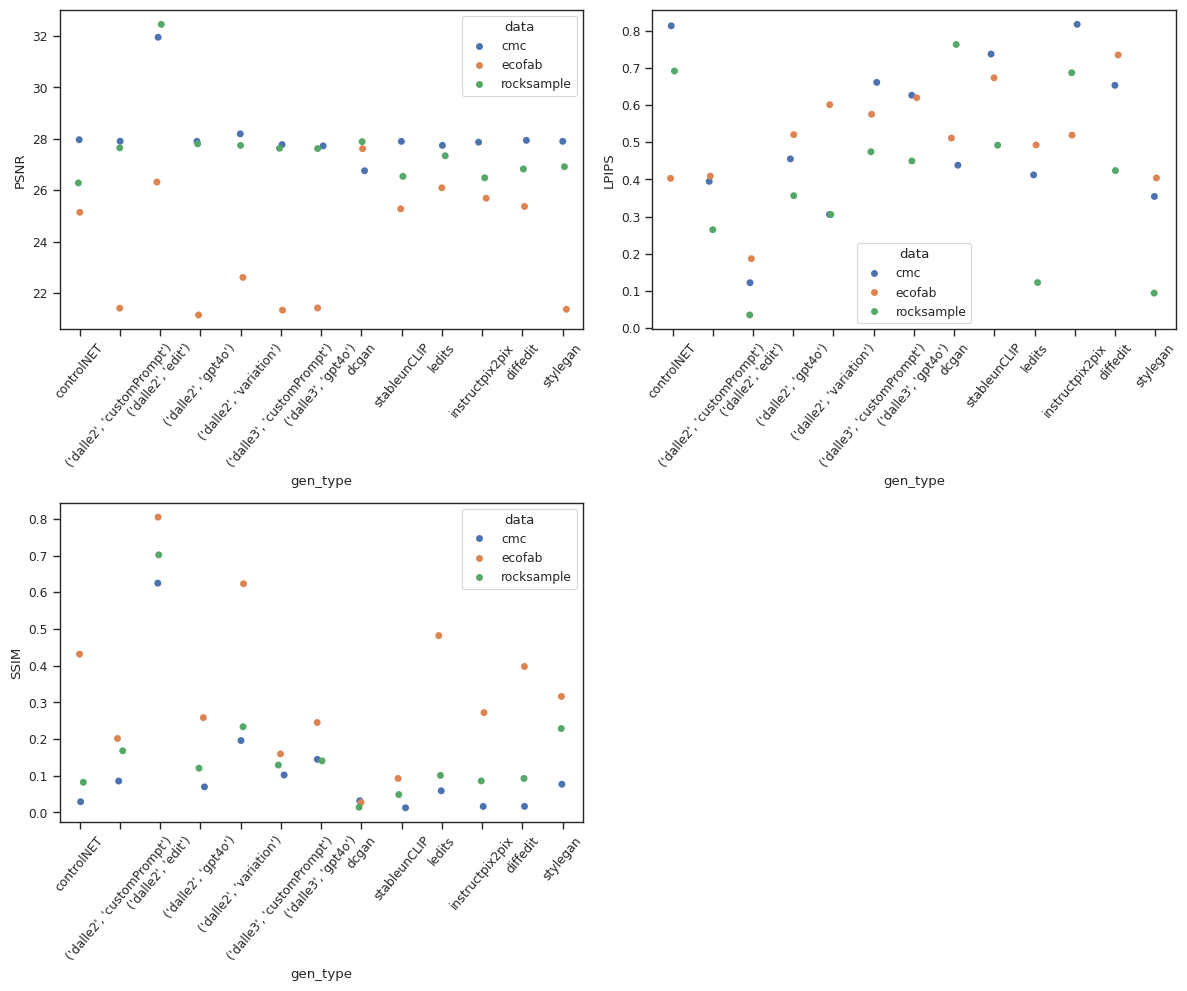

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")
sns.set_style("ticks", {
    "xtick.major.size": 8,
    "ytick.major.size": 8
})

# Create subplots
f, ax = plt.subplots(2, 2, figsize=(12, 10))

# PSNR
sns.stripplot(x="gen_type", y="psnr_avg", data=df, hue='data', ax=ax[0,0])
ax[0,0].set_ylabel("PSNR")
ax[0,0].set_xticklabels(ax[0,0].get_xticklabels(), rotation=50)

# LPIPS
sns.stripplot(x="gen_type", y="lpips_avg", data=df, hue='data', ax=ax[0,1])
ax[0,1].set_ylabel("LPIPS")
ax[0,1].set_xticklabels(ax[0,1].get_xticklabels(), rotation=50)


# SSIM
sns.stripplot(x="gen_type", y="ssim_avg", data=df, hue='data', ax=ax[1,0])
ax[1,0].set_ylabel("SSIM")
ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(), rotation=50)

ax[1,1].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
palette = sns.color_palette("colorblind")
palette

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

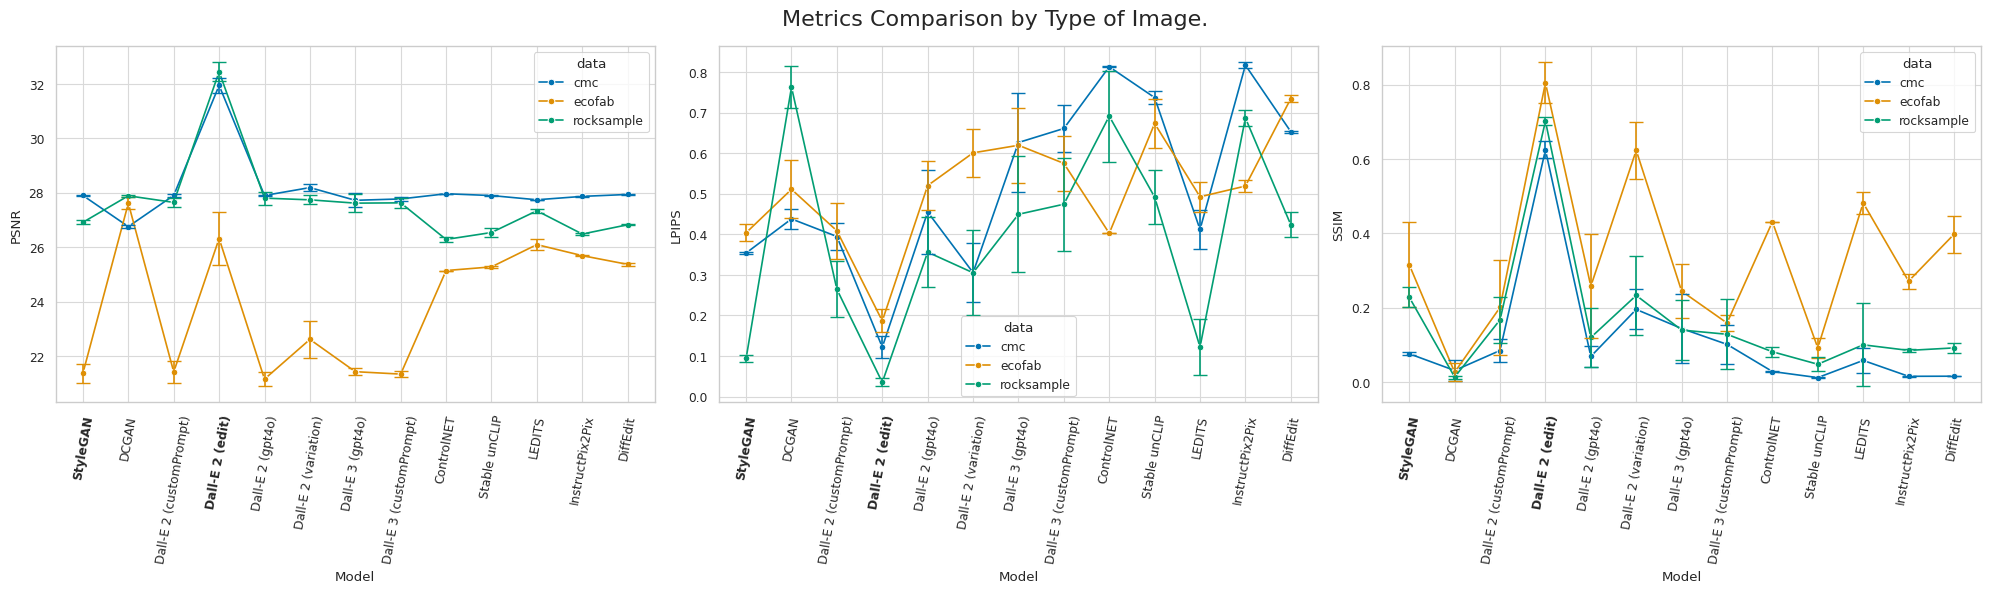

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

costumOrder_gen_type = ['stylegan', 'dcgan', "('dalle2', 'customPrompt')", "('dalle2', 'edit')",
       "('dalle2', 'gpt4o')", "('dalle2', 'variation')",
       "('dalle3', 'gpt4o')", "('dalle3', 'customPrompt')", 'controlNET',
       'stableunCLIP', 'ledits', 'instructpix2pix', 'diffedit']
df["gen_type"] = pd.Categorical(df["gen_type"], categories=costumOrder_gen_type, ordered=True)


sns.set_style("whitegrid", {
    "grid.color": ".85",       # Light gray grid
    "grid.linestyle": "-",     # Solid lines
    "grid.linewidth": 0.8      # Thin lines
})
sns.set_context("paper")

f, ax = plt.subplots(1, 3, figsize=(20, 6))

metrics = [
    ("psnr_avg", "psnr_std", "PSNR", ax[0]),
    ("lpips_avg", "lpips_std", "LPIPS", ax[1]),
    ("ssim_avg", "ssim_std", "SSIM", ax[2]),

]

palette = sns.color_palette("colorblind")

for (avg_col, std_col, ylabel, axis) in metrics:
    sns.lineplot(
        data=df,
        x="gen_type",
        y=avg_col,
        hue="data",
        marker="o",
        ax=axis,
        palette=palette,
        legend=True  # Prevent duplicate legends
    )

    # Add error bars manually
    grouped = df.groupby(["gen_type", "data"])[[avg_col, std_col]].mean().reset_index()
    for i, data_type in enumerate(df["data"].unique()):
        subset = grouped[grouped["data"] == data_type]
        axis.errorbar(
            x=subset["gen_type"],
            y=subset[avg_col],
            yerr=subset[std_col],
            fmt="none",
            capsize=5,
            color=palette[i]
        )

    axis.set_ylabel(ylabel)
    axis.set_xlabel("Model")

    xticks_renames = ['StyleGAN', 'DCGAN', "Dall-E 2 (customPrompt)", "Dall-E 2 (edit)",
       "Dall-E 2 (gpt4o)", "Dall-E 2 (variation)",
       "Dall-E 3 (gpt4o)", "Dall-E 3 (customPrompt)", 'ControlNET',
       'Stable unCLIP', 'LEDITS', 'InstructPix2Pix', 'DiffEdit']
    axis.set_xticklabels(xticks_renames, rotation=80)
    # Bold one specific tick (e.g., 'dcgan')
    for label in axis.get_xticklabels():
        if label.get_text() == "StyleGAN" or label.get_text() == "Dall-E 2 (edit)":
            label.set_fontweight("bold")

plt.suptitle('Metrics Comparison by Type of Image.', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


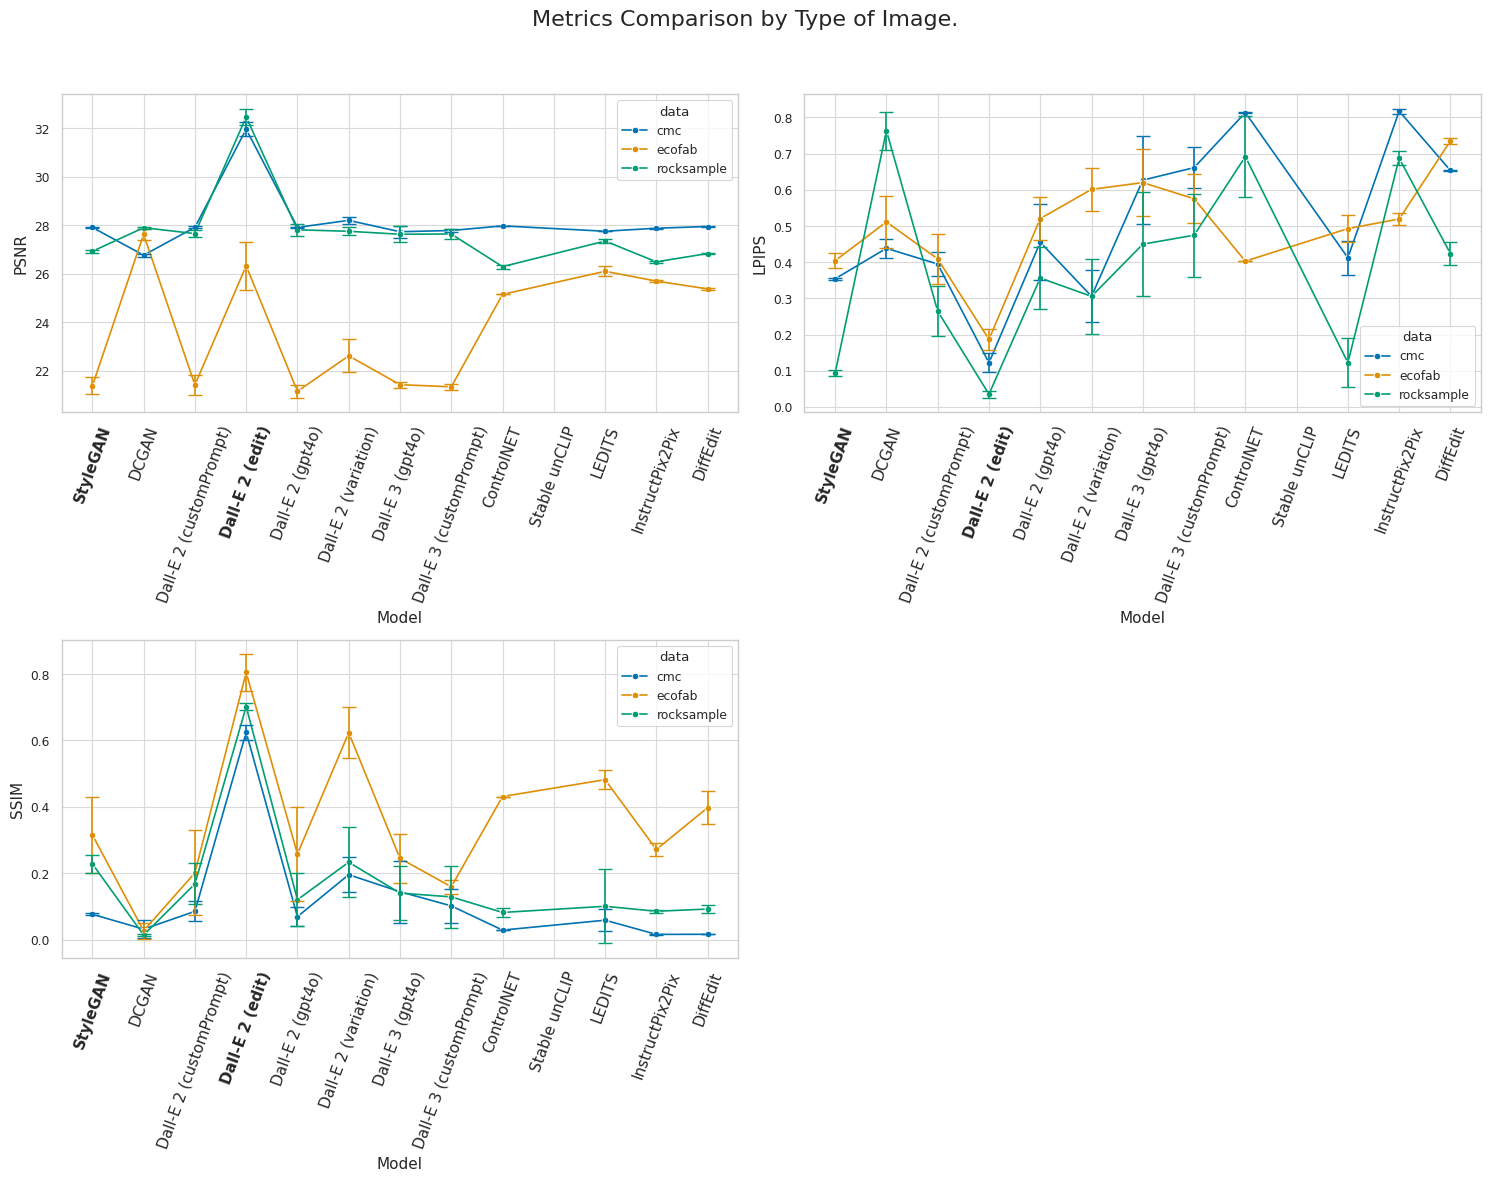

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

costumOrder_gen_type = ['stylegan', 'dcgan', "('dalle2', 'customPrompt')", "('dalle2', 'edit')",
       "('dalle2', 'gpt4o')", "('dalle2', 'variation')",
       "('dalle3', 'gpt4o')", "('dalle3', 'customPrompt')", 'controlNET',
       'stable unCLIP', 'ledits', 'instructpix2pix', 'diffedit']
df["gen_type"] = pd.Categorical(df["gen_type"], categories=costumOrder_gen_type, ordered=True)

sns.set_style("whitegrid", {
    "grid.color": ".85",
    "grid.linestyle": "-",
    "grid.linewidth": 0.8
})
sns.set_context("paper")

# Setup figure and gridspec
fig = plt.figure(figsize=(15, 12))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])  # 2 rows, 2 cols

# Assign subplots
ax1 = fig.add_subplot(gs[0, 0])  # First plot top-left
ax2 = fig.add_subplot(gs[0, 1])  # Second plot top-right
ax3 = fig.add_subplot(gs[1, 0])  # Third plot spans full bottom row

metrics = [
    ("psnr_avg", "psnr_std", "PSNR", ax1),
    ("lpips_avg", "lpips_std", "LPIPS", ax2),
    ("ssim_avg", "ssim_std", "SSIM", ax3),
]

palette = sns.color_palette("colorblind")

for (avg_col, std_col, ylabel, axis) in metrics:
    sns.lineplot(
        data=df,
        x="gen_type",
        y=avg_col,
        hue="data",
        marker="o",
        ax=axis,
        palette=palette,
        legend=True
    )

    # Add error bars
    grouped = df.groupby(["gen_type", "data"])[[avg_col, std_col]].mean().reset_index()
    for i, data_type in enumerate(df["data"].unique()):
        subset = grouped[grouped["data"] == data_type]
        axis.errorbar(
            x=subset["gen_type"],
            y=subset[avg_col],
            yerr=subset[std_col],
            fmt="none",
            capsize=5,
            color=palette[i]
        )

    axis.set_ylabel(ylabel, fontsize=11)
    axis.set_xlabel("Model", fontsize=11)

    xticks_renames = ['StyleGAN', 'DCGAN', "Dall-E 2 (customPrompt)", "Dall-E 2 (edit)",
       "Dall-E 2 (gpt4o)", "Dall-E 2 (variation)",
       "Dall-E 3 (gpt4o)", "Dall-E 3 (customPrompt)", 'ControlNET',
       'Stable unCLIP', 'LEDITS', 'InstructPix2Pix', 'DiffEdit']
    axis.set_xticklabels(xticks_renames, rotation=70, fontsize=11)
    # Bold one specific tick (e.g., 'dcgan')
    for label in axis.get_xticklabels():
        if label.get_text() == "StyleGAN" or label.get_text() == "Dall-E 2 (edit)":
            label.set_fontweight("bold")

plt.suptitle('Metrics Comparison by Type of Image.', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("/content/drive/MyDrive/CAMERA Stable Diffusion/metrics_comparison_updated.png")
plt.show()


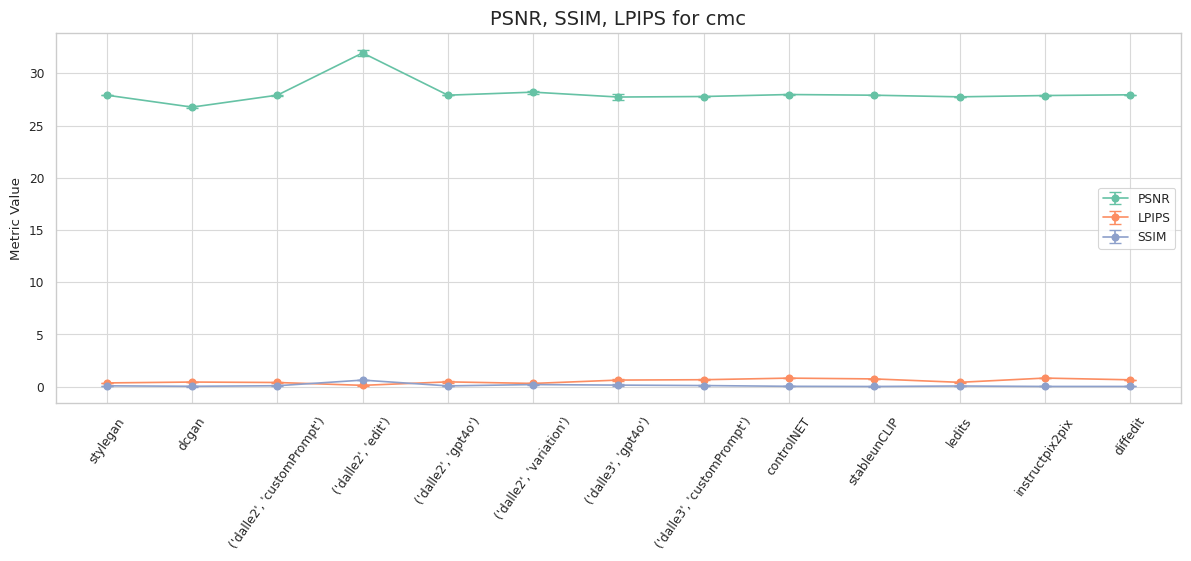

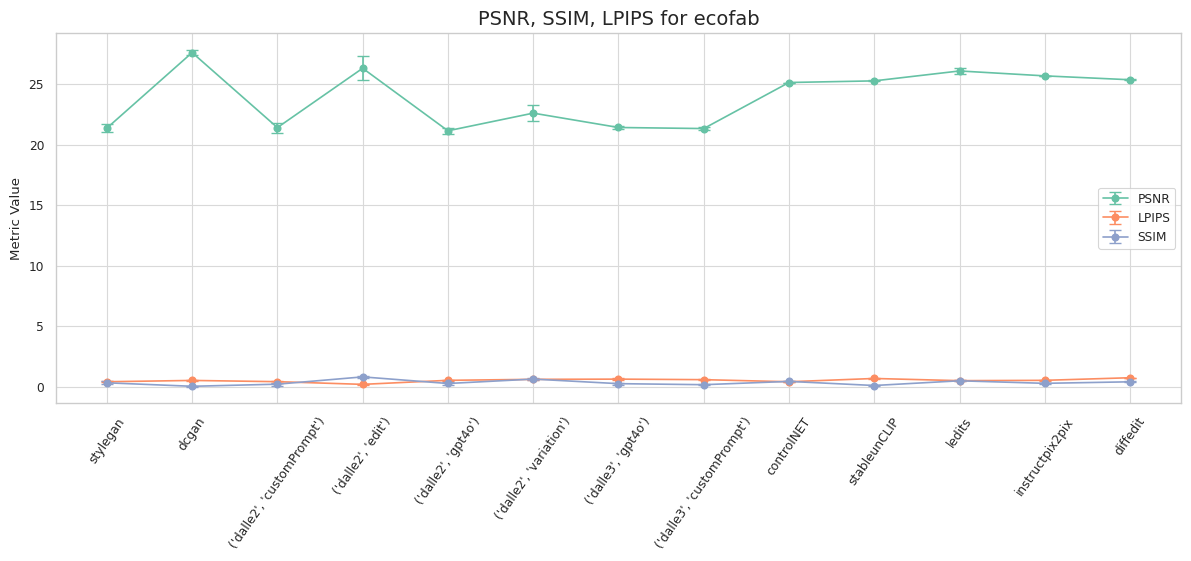

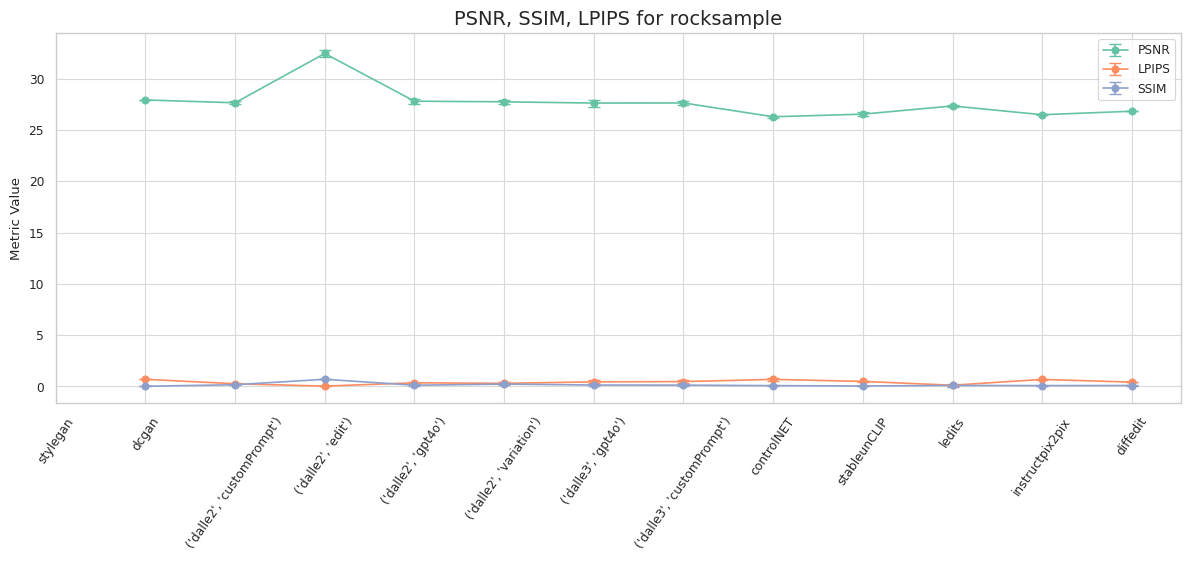

In [ ]:
customOrder_gen_type = ['stylegan', 'dcgan', "('dalle2', 'customPrompt')", "('dalle2', 'edit')",
       "('dalle2', 'gpt4o')", "('dalle2', 'variation')",
       "('dalle3', 'gpt4o')", "('dalle3', 'customPrompt')", 'controlNET',
       'stableunCLIP', 'ledits', 'instructpix2pix', 'diffedit']
df["gen_type"] = pd.Categorical(df["gen_type"], categories=customOrder_gen_type, ordered=True)

sns.set_style("whitegrid", {
    "grid.color": ".85",
    "grid.linestyle": "-",
    "grid.linewidth": 0.8
})
sns.set_context("paper")
palette = sns.color_palette("Set2")

metrics = [
    ("psnr_avg", "psnr_std", "PSNR"),
    ("lpips_avg", "lpips_std", "LPIPS"),
    ("ssim_avg", "ssim_std", "SSIM")
]

data_types = df["data"].unique()
# fig, axes = plt.subplots(1, len(data_types), figsize=(20, 6), sharex=True)

for data_type in df["data"].unique():
    # fig, ax = plt.subplots(figsize=(12, 6))
    fig, ax1 = plt.subplots(figsize=(12, 6))
    sub = df[df["data"] == data_type]

    for i, (avg_col, std_col, label) in enumerate(metrics):

      # Primary y-axis for PSNR
      grouped = sub.groupby("gen_type")[["psnr_avg", "psnr_std"]].mean().reset_index()
      ax1.errorbar(
          grouped["gen_type"],
          grouped["psnr_avg"],
          yerr=grouped["psnr_std"],
          label="PSNR",
          fmt='-o',
          color='C0')
      ax1.set_ylabel("PSNR", color='C0')

      # Secondary y-axis
      ax2 = ax1.twinx()

      for i, (avg_col, std_col, label) in enumerate([("ssim_avg", "ssim_std", "SSIM"), ("lpips_avg", "lpips_std", "LPIPS")]):
          grouped = sub.groupby("gen_type")[[avg_col, std_col]].mean().reset_index()
          ax2.errorbar(grouped["gen_type"], grouped[avg_col], yerr=grouped[std_col], label=label, fmt='-o', color=f"C{i+1}")
      ax2.set_ylabel("SSIM / LPIPS", color='C1')

    ax.set_title(f"PSNR, SSIM, LPIPS for {data_type} images", fontsize=14)
    ax.set_ylabel("Metric Value")
    ax.set_xticks(range(len(customOrder_gen_type)))
    ax.set_xticklabels(customOrder_gen_type, rotation=55)
    ax.legend()
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"/content/drive/MyDrive/CAMERA Stable Diffusion/metrics_{data_type}.png")
    plt.show()


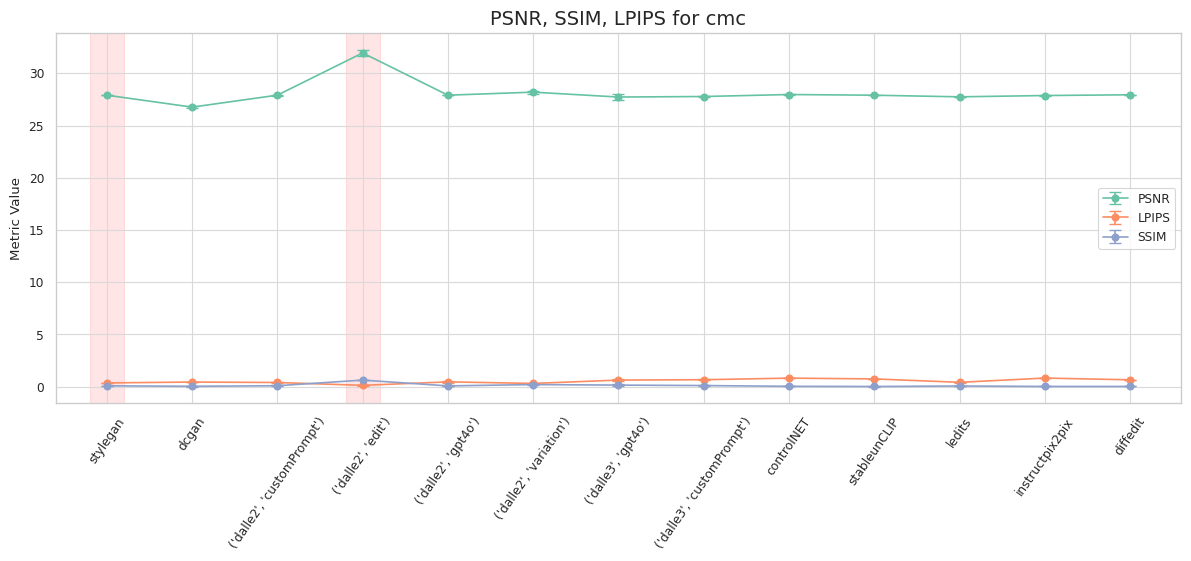

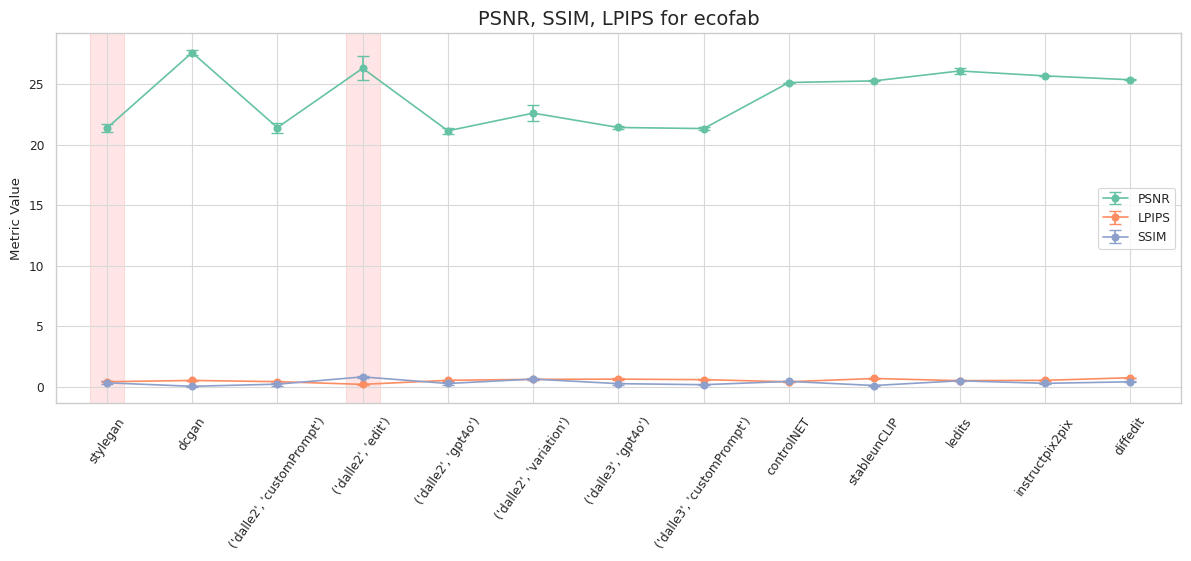

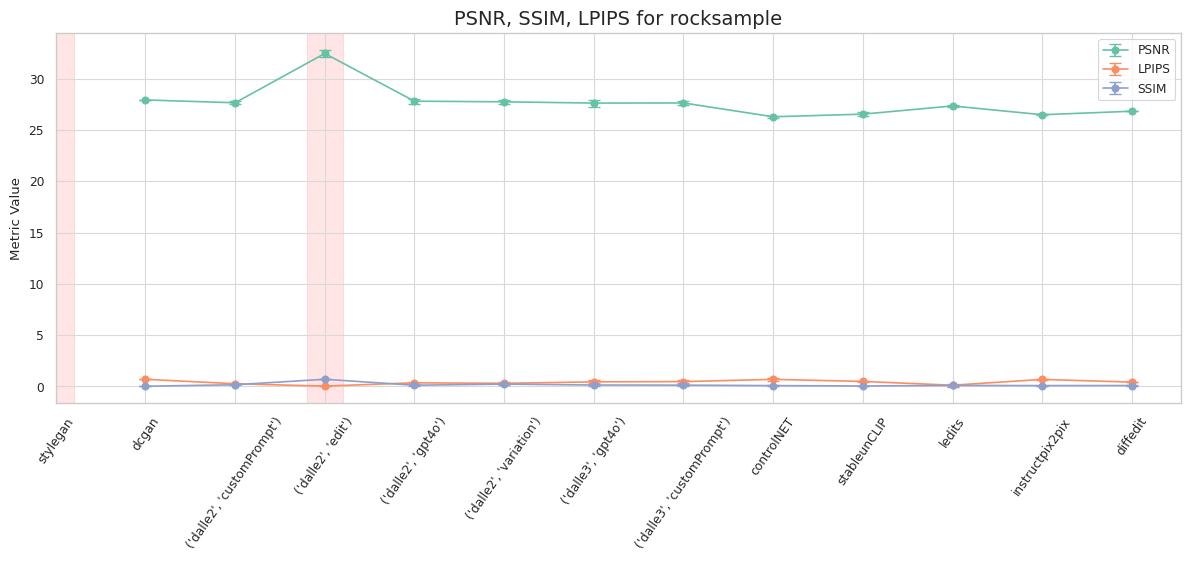

In [ ]:
import matplotlib.patches as patches

# Assume customOrder_gen_type is your ordered x-axis labels
highlight_models = ["stylegan", "('dalle2', 'edit')"]

for data_type in df["data"].unique():
    fig, ax = plt.subplots(figsize=(12, 6))
    sub = df[df["data"] == data_type]

    for i, (avg_col, std_col, label) in enumerate(metrics):
        grouped = sub.groupby("gen_type")[[avg_col, std_col]].mean().reset_index()
        ax.errorbar(
            x=grouped["gen_type"],
            y=grouped[avg_col],
            yerr=grouped[std_col],
            label=label,
            fmt='-o',
            capsize=4,
            color=palette[i]
        )

    # Highlight models using a red rectangle
    for model in highlight_models:
        if model in customOrder_gen_type:
            xpos = customOrder_gen_type.index(model)
            ax.add_patch(
                patches.Rectangle(
                    (xpos - 0.2, ax.get_ylim()[0]),  # x, y (bottom left)
                    width=0.4,
                    height=ax.get_ylim()[1] - ax.get_ylim()[0],
                    color='red',
                    alpha=0.1,
                    zorder=0
                )
            )

    ax.set_title(f"PSNR, SSIM, LPIPS for {data_type}", fontsize=14)
    ax.set_ylabel("Metric Value")
    ax.set_xticks(range(len(customOrder_gen_type)))
    ax.set_xticklabels(customOrder_gen_type, rotation=55)
    ax.legend()
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
